In [8]:
import numpy as np
from os.path import expanduser
import os
import json
import theano
import pyret.filtertools as ft
import pyret.visualizations as pyviz
#import deepretina.visualizations as viz
import preprocessing
from preprocessing import datagen, loadexpt
from utils import rolling_window
from keras.models import model_from_json
import h5py
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
%matplotlib inline
#%matplotlib qt

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load full STC of the experiment  
This is the normalized STC with (STA)(STA)^T subtracted

In [2]:
path_to_stc = '/Users/lmcintosh/Dropbox/deep-retina/saved/lenna.salamander/2015-12-04 10.26.59 Experiment STC/'
stc_filename = 'full_stc_experiment_15_10_07.h5'
f = h5py.File(os.path.join(path_to_stc, stc_filename), 'r')

In [3]:
stc = f['stc']

In [4]:
u,v = np.linalg.eigh(stc)

In [6]:
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points
            spine.set_smart_bounds(True)
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

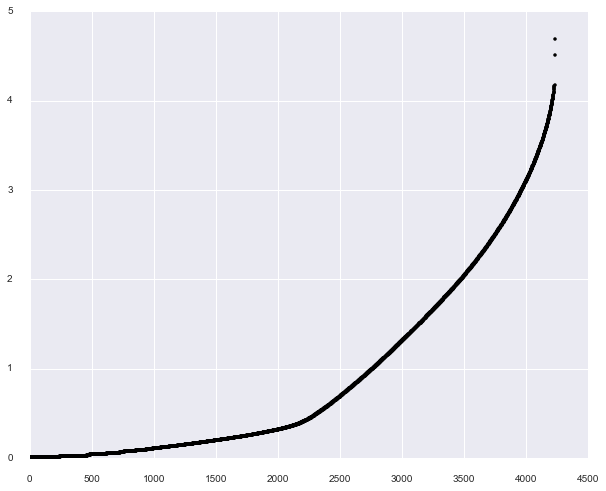

In [9]:
plt.plot(u, 'k.')
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

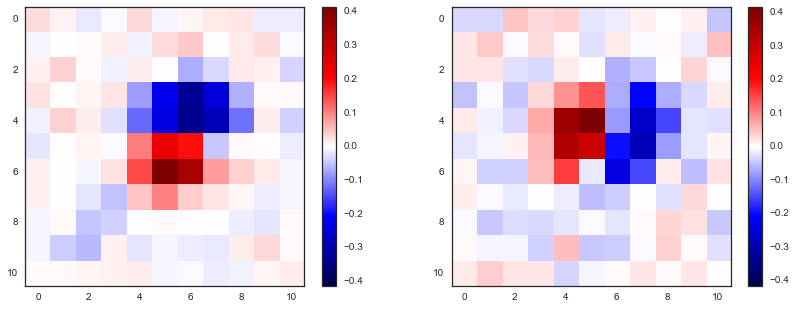

In [33]:
fig = plt.gcf()
fig.set_size_inches((14,5))
plt.subplot(1,2,1)
space, time = ft.decompose(v[:,-1].reshape((35,11,11)))
plt.imshow(space, interpolation='nearest', cmap='seismic', clim=[-np.max(np.abs(space)), np.max(np.abs(space))])
plt.colorbar()

plt.subplot(1,2,2)
space, time = ft.decompose(v[:,-2].reshape((35,11,11)))
plt.imshow(space, interpolation='nearest', cmap='seismic', clim=[-np.max(np.abs(space)), np.max(np.abs(space))])
plt.colorbar()

# Compute random STC

In [10]:
# whitenoise_train_unrolled = loadexpt(0, 'whitenoise', 'train', 40, roll=False)
whitenoise_train_rolled = loadexpt(0, 'whitenoise', 'train', 40, roll=True)

Loading training data... Done.


In [11]:
whitenoise_train_rolled.X.shape

(359762, 40, 50, 50)

In [12]:
np.mean(whitenoise_train_rolled.y)

7.1536721965425132

In [13]:
np.std(whitenoise_train_rolled.y)

17.963241871749414

### True firing rate of the cell is:

In [14]:
100 * (25761./whitenoise_train_rolled.y.shape[0])

7.160567263913364

### Choose random spikes

In [18]:
num_spikes = int((np.mean(whitenoise_train_rolled.y)/100) * len(whitenoise_train_rolled.X))

In [19]:
f = h5py.File(os.path.join(preprocessing.datadirs['lane.local'], '15-10-07/whitenoise.h5'), 'r')
time = np.array(f['train/time'][40:])

In [20]:
? np.random.choice

In [21]:
random_spikes = np.sort(np.random.choice(time, num_spikes, replace=False))

In [22]:
len(random_spikes)

25736

In [23]:
random_spikes[:10]

array([ 0.41028333,  0.48033   ,  0.75052   ,  0.95066333,  0.96067   ,
        1.01069667,  1.20083   ,  1.32092   ,  1.61112333,  1.76122333])

### Now get unrolled stimulus

In [24]:
del whitenoise_train_rolled

In [25]:
whitenoise_train_unrolled = loadexpt(0, 'whitenoise', 'train', 40, roll=False)

Loading training data... Done.


In [26]:
time.shape

(359762,)

In [27]:
whitenoise_train_unrolled.X[40:].shape

(359762, 50, 50)

In [59]:
tmp = np.where(whitenoise_train_unrolled.y > 36, 1, 0)
true_spike_times = time[np.array(tmp).astype('bool')]
sta_true, tax = ft.getsta(time, whitenoise_train_unrolled.X[40:], true_spike_times, 35)

In [30]:
sta_random, tax = ft.getsta(time, whitenoise_train_unrolled.X[40:], random_spikes, 35)

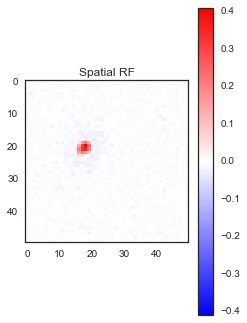

(<matplotlib.figure.Figure at 0x11b32d490>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x11b327090>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1119e0110>))

In [60]:
pyviz.plotsta(tax, sta_true)

# Reduce dimensionality of STC by cutting out a window around the RF

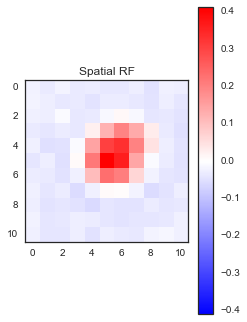

(<matplotlib.figure.Figure at 0x1193f5f10>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x10616cc50>,
  <matplotlib.axes._subplots.AxesSubplot at 0x119408d90>))

In [61]:
pyviz.plotsta(tax, ft.cutout(sta_true, idx=np.flipud(ft.filterpeak(sta_true)[1]), width=5))

In [62]:
Xcut = ft.cutout(whitenoise_train_unrolled.X[40:], idx=np.flipud(ft.filterpeak(sta_true)[1]), width=5)

In [63]:
Xcut.shape

(359762, 11, 11)

In [64]:
Xcut.dtype

dtype('float32')

In [65]:
sta_cut = ft.cutout(sta_true, idx=np.flipud(ft.filterpeak(sta_true)[1]), width=5)

In [66]:
sta_cut.shape

(35, 11, 11)

# Do STC

In [69]:
stc = np.zeros((35*11*11, 35*11*11))
for idx, s in enumerate(ft.getste(time, Xcut, random_spikes, 35)):
    sr = s.astype('float').ravel()
    if sr.size == (35*11*11):
        stc += np.outer(sr, sr)
        
    if idx % 500 == 0:
        print('{}'.format(100.*idx/len(random_spikes)))

0.0
1.94280385452
3.88560770905
5.82841156357
7.77121541809
9.71401927261
11.6568231271
13.5996269817
15.5424308362
17.4852346907
19.4280385452
21.3708423998
23.3136462543
25.2564501088
27.1992539633
29.1420578178
31.0848616724
33.0276655269
34.9704693814
36.9132732359
38.8560770905
40.798880945
42.7416847995
44.684488654
46.6272925085
48.5700963631
50.5129002176
52.4557040721
54.3985079266
56.3413117812
58.2841156357
60.2269194902
62.1697233447
64.1125271993
66.0553310538
67.9981349083
69.9409387628
71.8837426173
73.8265464719
75.7693503264
77.7121541809
79.6549580354
81.59776189
83.5405657445
85.483369599
87.4261734535
89.3689773081
91.3117811626
93.2545850171
95.1973888716
97.1401927261
99.0829965807


In [70]:
stc_normalized = stc/len(random_spikes)
stc_normalized -= np.outer(sta_cut.ravel(), sta_cut.ravel())

In [71]:
u_random,v_random = np.linalg.eigh(stc_normalized)

(0, 5)

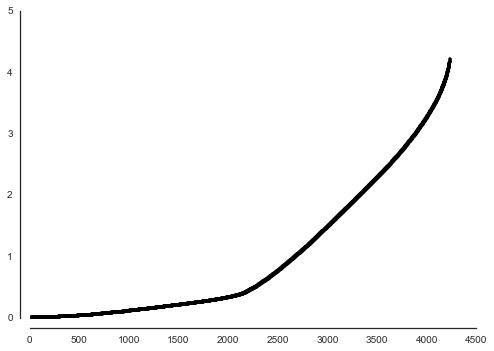

In [73]:
plt.plot(u_random, 'k.')
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])
plt.ylim([0,5])

In [81]:
counts_random, bin_edges_random = np.histogram(u_random, 100)

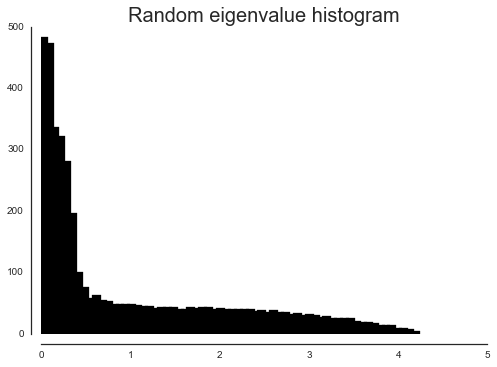

In [96]:
plt.bar(bin_edges_random[:-1], counts_random, .1, color='k')
plt.xlim([0,5])
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])
plt.title('Random eigenvalue histogram', fontsize=20)

In [83]:
counts_true, bin_edges_true = np.histogram(u, 100)

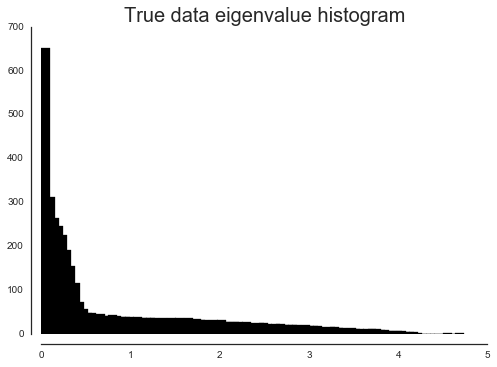

In [95]:
plt.bar(bin_edges_true[:-1], counts_true, .1, color='k')
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])
plt.title('True data eigenvalue histogram', fontsize=20)

In [86]:
path_to_stc = '/Users/lmcintosh/Dropbox/deep-retina/saved/lenna.salamander/2015-12-07 12.16.59 Convnet STC/'
stc_filename = 'full_stc_convnet_15_10_07.h5'
h = h5py.File(os.path.join(path_to_stc, stc_filename), 'r')

In [87]:
model_stc = h['stc']

In [88]:
u_model,v_model = np.linalg.eigh(model_stc)

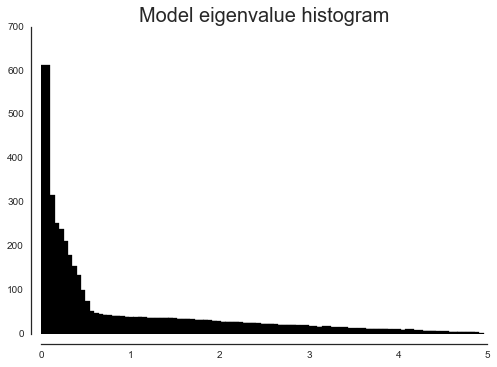

In [94]:
counts_model, bin_edges_model = np.histogram(u_model, 100)
plt.bar(bin_edges_model[:-1], counts_model, .1, color='k')
plt.xlim([0,5])
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])
plt.title('Model eigenvalue histogram', fontsize=20)

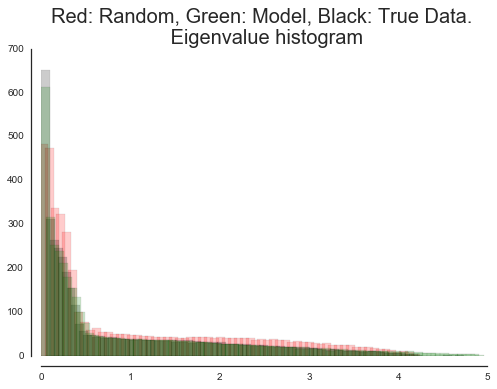

In [97]:
plt.bar(bin_edges_random[:-1], counts_random, .1, color='r', alpha=.2)
plt.bar(bin_edges_true[:-1], counts_true, .1, color='k', alpha=.2)
plt.bar(bin_edges_model[:-1], counts_model, .1, color='g', alpha=.2)
plt.xlim([0,5])
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])
plt.title('Red: Random, Green: Model, Black: True Data. \n Eigenvalue histogram', fontsize=20)

# Load STC with more data points

In [98]:
path_to_stc = '/Users/lmcintosh/Dropbox/deep-retina/saved/lenna.salamander/2015-12-08 21.11.15 Convnet STC Long/'
stc_filename = 'full_stc_convnet_long_15_10_07.h5'
g = h5py.File(os.path.join(path_to_stc, stc_filename), 'r')

In [99]:
stc_long = g['stc']

In [100]:
u_long, v_long = np.linalg.eigh(stc_long)

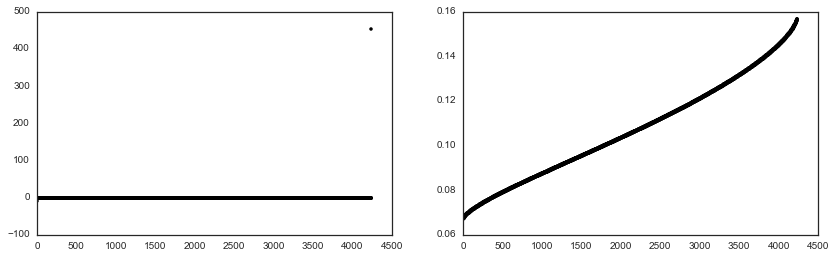

In [108]:
fig = plt.gcf()
fig.set_size_inches((14,4))
plt.subplot(1,2,1)
plt.plot(u_long, 'k.')
plt.subplot(1,2,2)
plt.plot(u_long[1:-1], 'k.')

In [118]:
u_long[-1]

453.40969562714184

In [119]:
u_long[-2]

0.15675305390074751

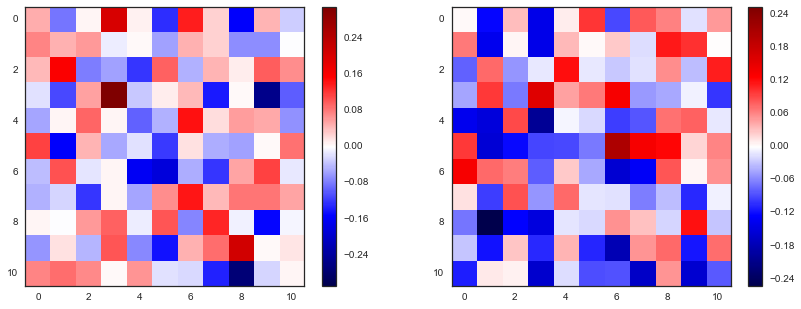

In [145]:
fig = plt.gcf()
fig.set_size_inches((14,5))
plt.subplot(1,2,1)
space, time = ft.decompose(v_long[:,-1].reshape((35,11,11)))
plt.imshow(space, interpolation='nearest', cmap='seismic', clim=[-np.max(np.abs(space)), np.max(np.abs(space))])
plt.colorbar()

plt.subplot(1,2,2)
space, time = ft.decompose(v_long[:,-2].reshape((35,11,11)))
plt.imshow(space, interpolation='nearest', cmap='seismic', clim=[-np.max(np.abs(space)), np.max(np.abs(space))])
plt.colorbar()

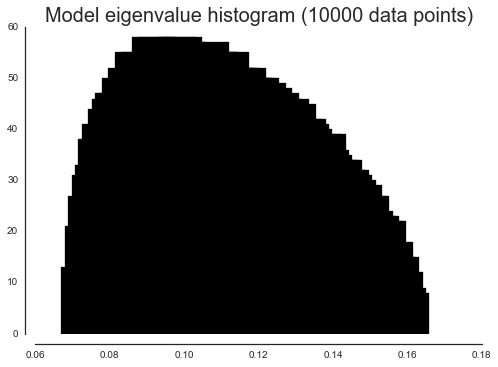

In [114]:
counts_model, bin_edges_model = np.histogram(u_long[1:-1], 100)
plt.bar(bin_edges_model[:-1], counts_model, .01, color='k')
#plt.xlim([0,5])
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])
plt.title('Model eigenvalue histogram (10000 data points)', fontsize=20)

0.21215570489813948

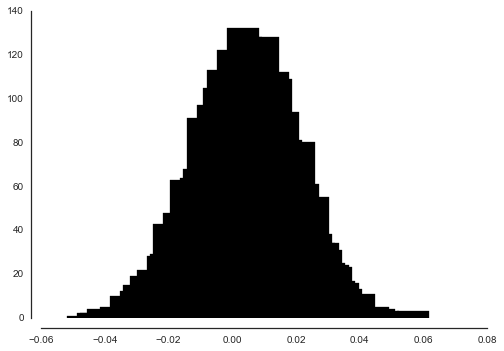

In [125]:
counts_diag, bin_edges_diag = np.histogram(np.diag(v_long), 100)
plt.bar(bin_edges_diag[:-1], counts_diag, .01, color='k')
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])
np.mean(np.diag(stc_long))

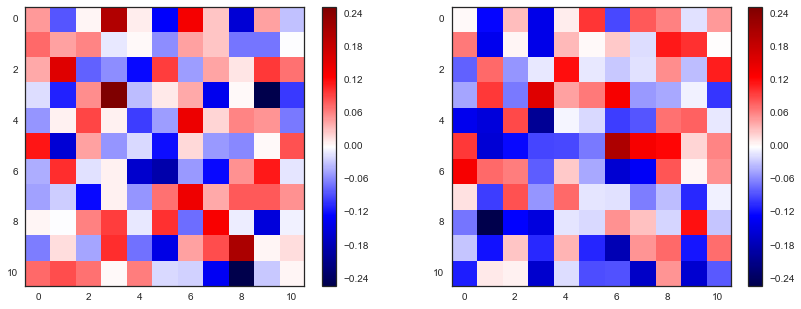

In [147]:
fig = plt.gcf()
fig.set_size_inches((14,5))
plt.subplot(1,2,1)
space_1, time_1 = ft.decompose(v_long[:,-1].reshape((35,11,11)))
plt.imshow(space_1, interpolation='nearest', cmap='seismic', clim=[-np.max(np.abs(space)), np.max(np.abs(space))])
plt.colorbar()

plt.subplot(1,2,2)
space_2, time_2 = ft.decompose(v_long[:,-2].reshape((35,11,11)))
plt.imshow(space_2, interpolation='nearest', cmap='seismic', clim=[-np.max(np.abs(space)), np.max(np.abs(space))])
plt.colorbar()

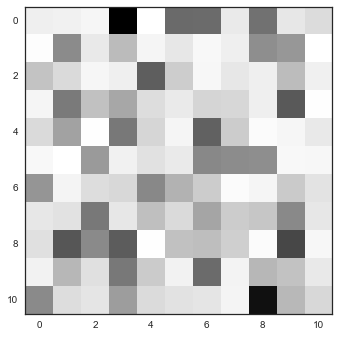

In [151]:
plt.imshow(np.abs(space_2 - space_1))

# Get just the spatial STC (projected along temporal kernel of STA)

In [ ]:
path_to_stc = '/Users/lmcintosh/Dropbox/deep-retina/saved/lenna.salamander/2015-12-09 09.59.04 Convnet STC Long/'
stc_filename = 'full_stc_convnet_long_15_10_07.h5'
j = h5py.File(os.path.join(path_to_stc, stc_filename), 'r')
stc_space = j['stc']